In [6]:
import load_data_v1 as ld
import preproccess_image as pi
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load data from one image
root_folder = r'E:\Juyue\Kaggle_Data\sample\sample\subject_1'
data = ld.load_data_for_one_subject(root_folder)

FilePosition 512
FilePosition 512


In [3]:
data['.a3d'].shape

(512, 512, 660)

In [3]:
# use the front imgae to get the horizontal line 
I_0 = np.flipud(data['.a3daps'][:,:,0].transpose())
I_0_mask = pi.create_mask_from_image(I_0)
segmentation = pi.find_segmentation_line_0(I_0_mask)

In [5]:
segmentation['hor']

{'chest': 257,
 'foot': 655,
 'groin': 440,
 'head': 136,
 'knee_lower': 601,
 'knee_upper': 547,
 'left_elbow': 210,
 'neck': 196,
 'right_elbow': 218,
 'thigh': 483,
 'waist': 364}

In [6]:
import matplotlib.pyplot as plt


left_elbow
right_elbow
head
neck
chest
waist
thigh
knee_upper
knee_lower
foot
groin


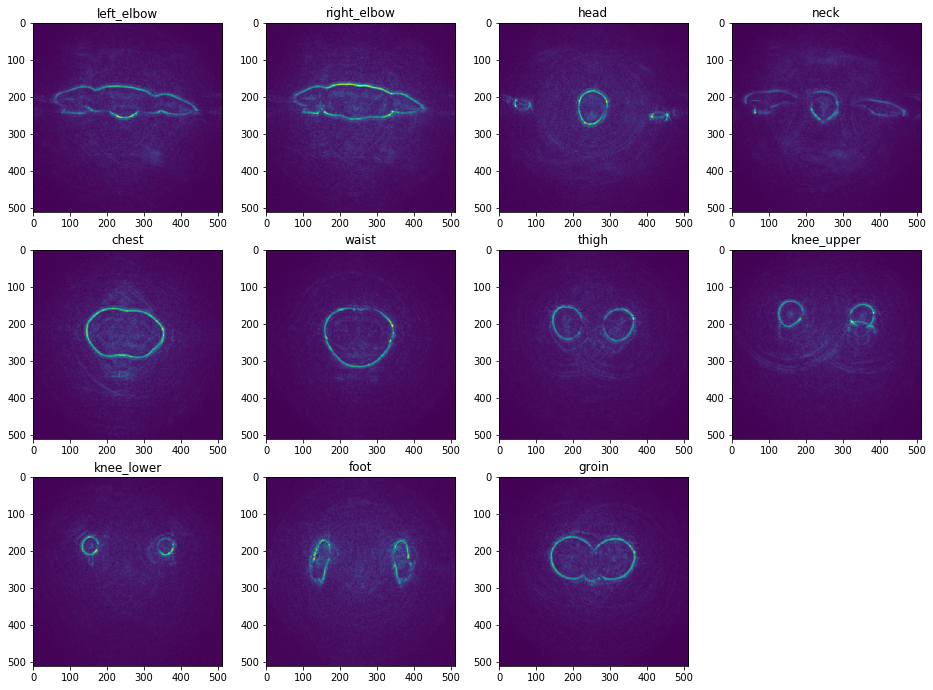

In [8]:
import matplotlib.pyplot as plt
import copy as cp
%matplotlib inline
# use the cross-section to get the vertical line
# There are8 lines to find, different cross section use different value... good enough untill chest
I_stack = data['.a3d']
I_stack_upsidedown = cp.copy(I_stack[:, :, -1:0:-1])
fig = plt.figure(figsize=(16, 16))
counter = 1
for key, value in segmentation['hor'].items():
    ax = plt.subplot(4, 4, counter)
    counter = counter + 1
#     print(value)
    I = np.flipud(I_stack_upsidedown[:,:,value].transpose())
    ax.imshow(I)
    print(key)
    plt.title(key)

In [163]:
# from chest to hip joint, get 8 points.
# from hip joint to foot, only two points.
# above chest, not necessary.
# calculate the distance between those points to the center...

def find_segmentation_line_cross_section_leg(I,  plot_flag = False, ax = None):
    import numpy as np
    n_points = 5;
    n_smooth = 10;
    
    (n_x, n_y) = I.shape
    middle_line = int(n_y /2)

    
    left_position = np.zeros(n_x)
    right_position = np.zeros(n_x)
    for xx in range(n_x):
        this_horizontal_line = I[xx, :]
        line_left = cp.copy(this_horizontal_line)
        line_left[int(n_x/2):] = False 
        if np.sum(line_left) > n_points :
            left_position[xx] =  np.mean(pi.find_matlab_style(line_left, n_points, 'first'))

        line_right = cp.copy(this_horizontal_line)
        line_right [:int(n_x/2)] = False 
        if np.sum(line_right) > n_points :
            right_position[xx]=  np.mean(pi.find_matlab_style(line_right, n_points, 'last'))

                
    left_position = pi.smooth(left_position, n_smooth)
    right_position = pi.smooth(right_position, n_smooth)
    
    left_diff = np.concatenate((np.zeros(1), np.diff(left_position)))
    right_diff = np.concatenate((np.zeros(1), np.diff(right_position)))
    
#     plt.subplot(3,2,1)
#     plt.plot(left_position)
#     plt.subplot(3,2,2)
#     plt.plot(right_position);
#     plt.subplot(3,2,3)
#     plt.plot( np.concatenate((np.zeros(1), np.diff(left_position))));
#     plt.subplot(3,2,4)
#     plt.plot(np.concatenate((np.zeros(1), np.diff(right_position))));
#     plt.show()

    image_mask = np.ones(n_y).astype(np.int64)
    
    dummy, left_foot_top =  pi.find_extreme_in_a_region(left_diff,   image_mask, 'max');
    dummy, right_foot_top =  pi.find_extreme_in_a_region(right_diff, image_mask, 'max');
    dummy, left_foot_bottom =  pi.find_extreme_in_a_region(left_diff,    image_mask, 'min');
    dummy, right_foot_bottom =  pi.find_extreme_in_a_region(right_diff,  image_mask, 'min');
    
    top_line = int((left_foot_top + right_foot_top)/2)
    bottom_line = int((left_foot_bottom + right_foot_bottom)/2)
    
    #     fig = plt.figure(figsize = (4,4))
    
    if plot_flag:
        fig = plt.figure(figsize = (4,4))
        plt.imshow(I)
        print(left_position[left_foot_top + 1])
        print(left_position[left_foot_bottom - 1])
        plt.plot([left_position[left_foot_top + 1], right_position[right_foot_top + 2]], [left_foot_top, right_foot_top],'k-')
        plt.plot([left_position[left_foot_bottom - 1], right_position[right_foot_bottom - 2]], [left_foot_bottom, right_foot_bottom],'r-')
        plt.show()
    
    middle_line = np.array([top_line, bottom_line])
    return middle_line
    
    

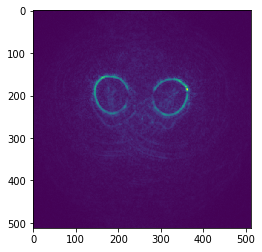

thigh
[153 252]


In [169]:
counter = 1
key = 'thigh'
value = segmentation['hor'][key]
I = np.flipud(I_stack_upsidedown[:,:,value].transpose())
plt.imshow(I)
plt.show()
print(key)
I_mask_this = pi.create_mask_from_image(I)
I_mask_this = dilate_and_erode_cross_section_binary(I_mask_this)
middle_line = find_segmentation_line_cross_section_leg(I_mask_this,  plot_flag = False)
print(middle_line)

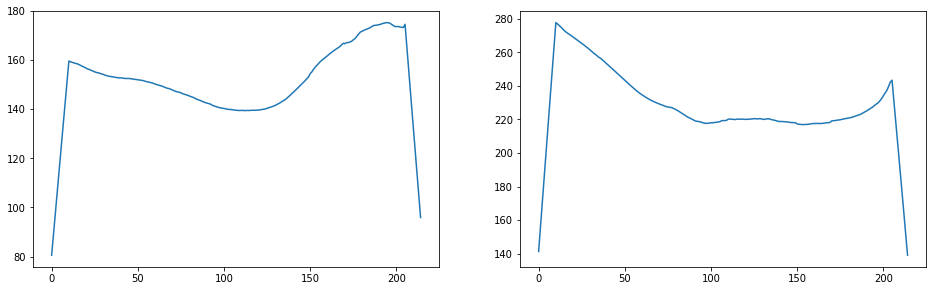

In [195]:
fig = plt.figure(figsize=(16, 16))
smooth_result_leg = np.zeros_like(distance_to_center_leg)
for ii in range(2):
    ax = plt.subplot(3,2,ii + 1)
    smooth_result_leg[ii,:] = pi.smooth( distance_to_center_leg[ii,:], 20)
    ax.plot(smooth_result_leg[ii,:])

In [ ]:
def find_segmentation_line_cross_section_trunk(I,  plot_flag = False, ax = None):
    import numpy as np
    n_points = 5;
    n_smooth = 5;
    wid_brain = 30;
    
    (n_x, n_y) = I.shape
    middle_line = int(n_y /2)
    y_cord = np.array([middle_line - wid_brain, middle_line, middle_line + wid_brain])
    n_point_measure = len(y_cord)
 
    top_position = np.zeros(n_y).astype(np.float64)
    bottom_position = np.zeros(n_y).astype(np.float64)
    for yy in range(n_y):
        this_vertical_line = I[:, yy]
        if np.sum(this_vertical_line) > n_points:
            top_position[yy] = np.mean(pi.find_matlab_style(this_vertical_line, n_points, 'first'))
            bottom_position[yy] = np.mean(pi.find_matlab_style(this_vertical_line, n_points , 'last'))
            
    top_position = pi.smooth(top_position, n_smooth)
    bottom_position = pi.smooth(bottom_position, n_smooth)
    
    back_cord = top_position[y_cord]
    front_cord = bottom_position[y_cord] 
    # 6 pointd to compute.
    distance_to_center_top = np.sqrt((back_cord - middle_line)**2 + (y_cord  - middle_line)**2)
    distance_to_center_bottom = np.sqrt((front_cord - middle_line)**2 + (y_cord  - middle_line)**2)
#     plt.plot(top_position)
#     plt.show()
    
    if plot_flag:
        if ax is None:
            plt.imshow(I)
            plt.plot(y_cord, back_cord,'k-')
            plt.plot(y_cord, front_cord,'r-')
            plt.show()

        else:
            ax.imshow(I)
            ax.plot(y_cord, back_cord,'k-')
            ax.plot(y_cord, front_cord,'r-')  
        
    distance_to_center = np.concatenate((distance_to_center_top, distance_to_center_bottom))
    return distance_to_center

left_elbow
right_elbow
head
neck
chest
waist
thigh
knee_upper
knee_lower
foot
groin


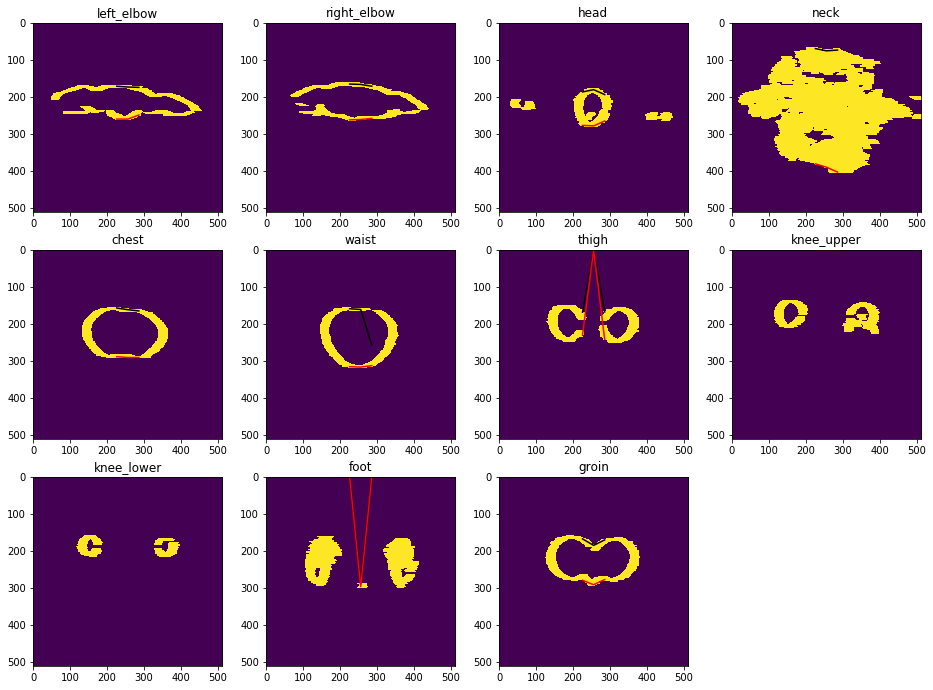

In [23]:

# look at the selected points, and corresponded value,
counter = 1
fig = plt.figure(figsize=(16, 16))
# create very agressive  and erosion.

for key, value in segmentation['hor'].items():
    ax = plt.subplot(4, 4, counter)
    counter = counter + 1
#     print(value)
    I = np.flipud(I_stack_upsidedown[:,:,value].transpose())
    ax.imshow(I)
    print(key)
    plt.title(key)
#     
    I_mask_this = pi.create_mask_from_image(I)
    I_mask_this = dilate_and_erode_cross_section_binary(I_mask_this)
    find_segmentation_line_cross_section(I_mask_this,  plot_flag = True, ax = ax)
    

In [24]:
#  get the middle line for the trunk.
chest_to_groin = range(segmentation['hor']['chest'],segmentation['hor']['groin'])
distance_to_center = np.zeros((6, len(chest_to_groin)))
for ii, idx in enumerate(chest_to_groin):
    I = np.flipud(I_stack_upsidedown[:,:,idx].transpose())
    I_mask_this = pi.create_mask_from_image(I)
    I_mask_this = dilate_and_erode_cross_section_binary(I_mask_this)
    distance_to_center[:, ii] = find_segmentation_line_cross_section(I_mask_this)
    

C:\ProgramData\Anaconda3\envs\tensorflow_kaggle_clone\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


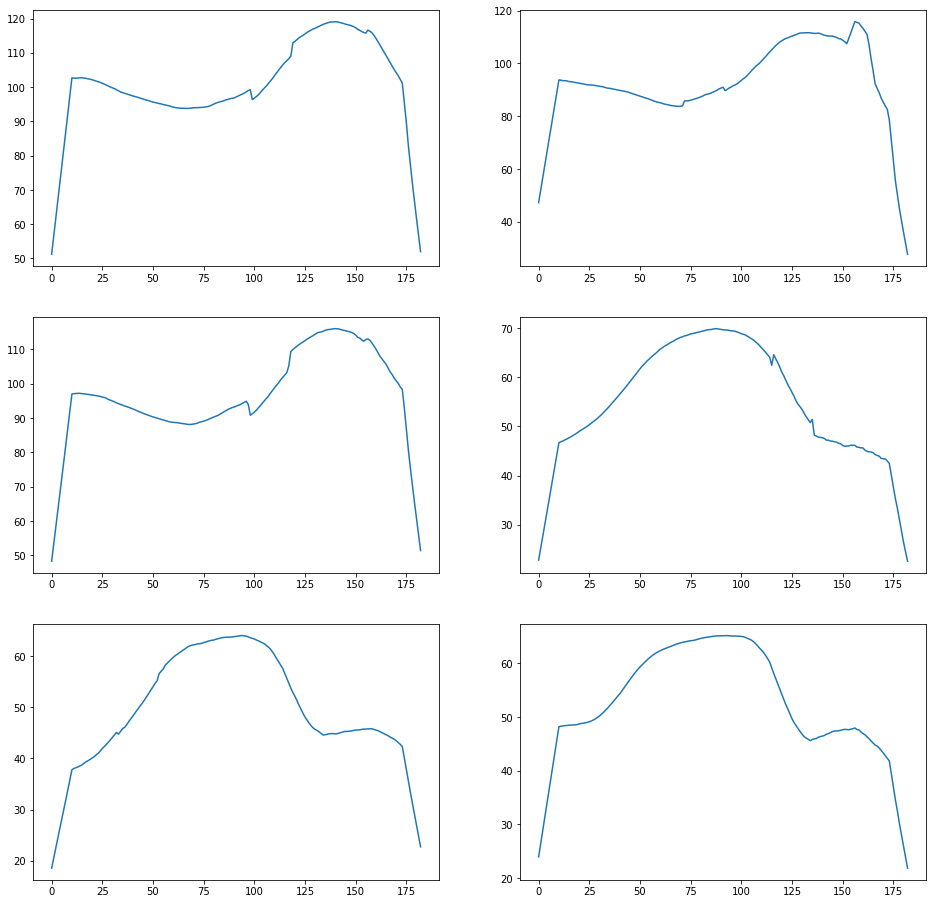

In [27]:
fig = plt.figure(figsize=(16, 16))
smooth_result = np.zeros_like(distance_to_center)
for ii in range(6):
    ax = plt.subplot(3,2,ii + 1)
    smooth_result[ii,:] = pi.smooth(distance_to_center[ii,:], 20)
    ax.plot(smooth_result[ii,:])
#  smooth out the result here...
middle_body_line = np.zeros((6, 660))
middle_body_line[:, segmentation['hor']['chest']:segmentation['hor']['groin']] = smooth_result

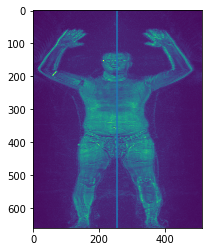

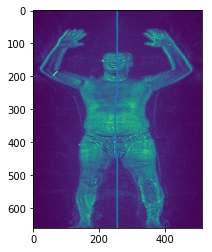

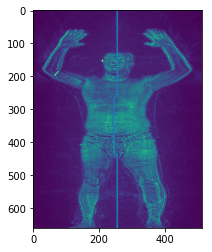

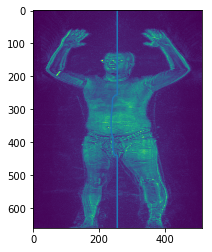

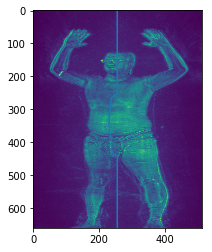

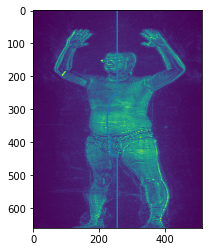

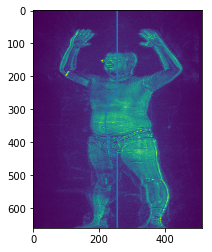

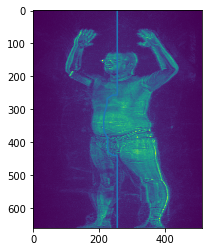

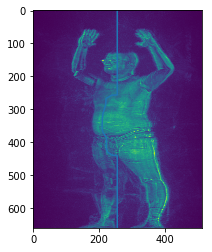

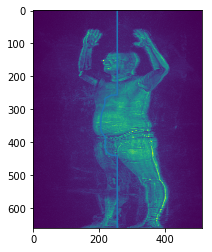

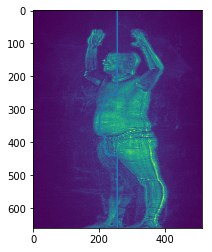

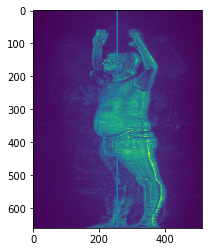

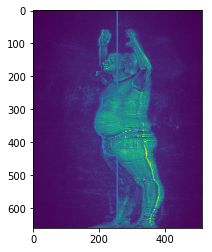

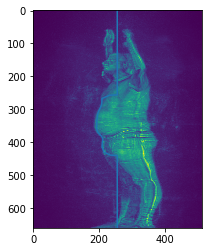

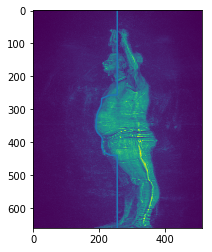

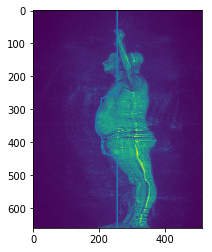

In [35]:

I_aps = data['.a3daps']
for ang_idx in range(16):
    I_2 = np.copy(np.flipud(I_aps[:,:, ang_idx].transpose())) 
    plt.figure;
    plt.imshow(I_2)
    n_x = 660
    reference_line = np.ones(n_x).astype(np.int64) * 255

    ang = ang_idx * 360/64 + 180
    new_line = segmetation_vertical_transformation_one_value(middle_body_line[5,:], reference_line, ang)
    plt.plot(new_line, np.arange(n_x))
    plt.show()